# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight alterations to the path of massless particles like light - and also massive particles - in the vicinity of black holes. We start with the Schwarzschild metric which describes particle motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

Here we add quantum corrections to our Schwarzschild black hole model. The corrections are derived in a paper by Saeed Rastgoo and colleagues. Past researchers found they could weave uncertainty-inspired quantum physics in a Schwarzschild black hole and the interior would behave according to observation but the math breaks down where spacetime flattens i.e. in the asymptotic region. To rectify this the team borrows an idea from 'Loop Quantum Gravity', namely that quantum parameters (QM) are momentum-dependent. This leads to an improvement to the interior model, which also works when extrapolated out to a full spacetime.

In [ ]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.integrate import solve_ivp
import sympy as sp
import OGRePy as gr
from IPython.display import display, Math
from scipy.interpolate import interp1d

**OGRePy: An <u>O</u>bject-Oriented <u>G</u>eneral <u>Re</u>lativity Package for <u>Py</u>thon\
By [Barak Shoshany](https://github.com/bshoshany) ([baraksh@gmail.com](mailto:baraksh@gmail.com)) ([baraksh.com](https://baraksh.com/))\
v1.3.0 (2025-02-04)\
GitHub repository: <https://github.com/bshoshany/OGRePy>\
Documentation: <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.ipynb">.ipynb</a>, <a href="c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.pdf">.pdf</a>, <a href="#" onclick="window.open('file:///c:/Users/suzan/AppData/Local/Programs/Python/Python312/Lib/site-packages/OGRePy/docs/OGRePy_Documentation.html', '_blank')">.html</a>**

**OGRePy**: You have the latest version of the package.

In [10]:
# assign r as a symbol
r = gr.sym('r', nonnegative=True)

# Improved Metric with Quantum Corrections

The following code defines functions that derive from the improved metric: a quantum-corrected variation of the Schwarzschild (SC) metric. Like the classical SC metric,

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$

the improved metric represents a static, spherically symmetric spacetime. Due to spherical symmetry we can confine the direction of angular momentum to $\theta = \frac{\pi}{2}$ and the conserved magnitude to $L = h(r) \frac{d\phi}{d\lambda}$. Since the metric is independent of 't' we can write the conserved energy as, $E = -f(r) \frac{dt}{d\lambda}$. As with the SC metric we can integrate once to get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the metric functions, the conserved quantities, E and L and $\epsilon$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

an expression that is comparable to Newtonian gravitational potential energy. Below we define the metric functions, Effective Potential, and Equations of Motion for the quantum-corrected metric. We also get a new version of $\frac{dr}{d\lambda}$, 

$$\frac{dr}{d\lambda} = \left( \frac{1}{g(r)} \left( \frac{E^2}{f(r)} + \left( \epsilon - \frac{L^2}{h(r)} \right) \right) \right)^{\frac{1}{2}}$$


In [ ]:
# block 1 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# get schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

def E_at_vmax(v_max):
    return gr.s.sqrt(max(0, v_max))

# lamda can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    squared = g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) + (epsilon - L**2 / h(r, M, Q_c)))
    dr_dlamda = gr.s.sqrt(max(squared, 0))  # ensure non-negative input

    return [dt_dlamda, dr_dlamda, dphi_dlamda]


# Assign Values to Constants

Assign values for Mass (central massive object), Energy and Angular momentum of the orbiting particle, and a set of values for the quantum parameters (QM) to see how quantum effects change effective potential.

In [ ]:
# block 2 - assign test values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
# test values of quantum parameters
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75
Q_c4 = 1.0

# conserved quantities
# for SC and quantum Geodesics testing I will constrain L and see what happens when I vary total energy E of the particle and 
L1 = 4.3 # angular momentum of orbiting particle
E1 = 1.0 # test value of particle total energy

# calculate and print SC metric components at a given radian distance from the BH and BH mass.
f1 = f(r1, M1, Q_b1, Q_c1)
g1 = g(r1, M1, Q_b1, Q_c1)
h1 = h(r1, M1, Q_c1)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.900593754879089
g(r) = 1.11107255028028
h(r) = 400.00000000097657


# Effective Potential as a function of radius from the black hole

Next we explore the effective potential. To have orbits (around a massive object) we need either a maxima or a minima. Minima produce very stable orbits. Maxima can sustain an orbit but the object is easily knocked out of this orbit. If we plot $V_{\text{eff}}(r)$, constrain M and L and vary the quantum parameters (QM) we find that the extremum (maximum) is always at 3*M when QM = 0 and move to the left as QM increase from 0 to 1.

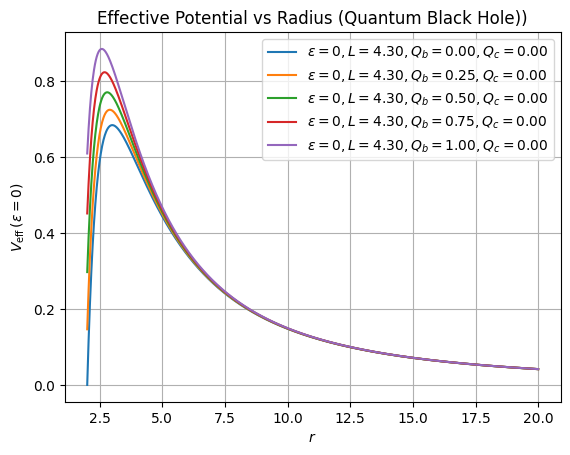

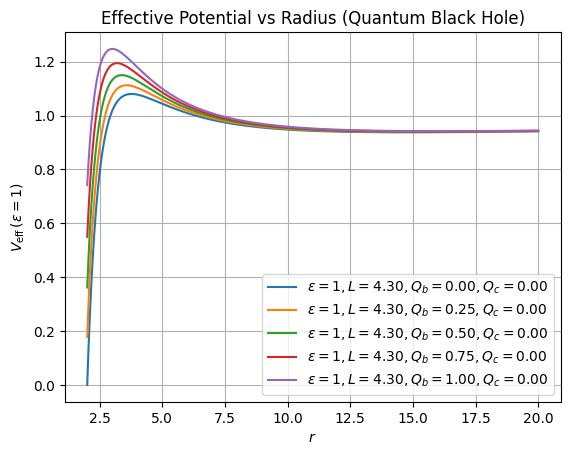

In [26]:
# block 3 - study v_eff as a function of r given test values for M, L.
# span of r values
r_vals = np.linspace(rs1, 10*rs1, 1000)

# get list of effective potential values for sigma=0
v_eff_vals_Q0 = np.array([v_eff(i, M1, L1, Q_b0, Q_c0, epsilon=0) for i in r_vals])
v_eff_vals_Q1 = np.array([v_eff(i, M1, L1, Q_b1, Q_c0, epsilon=0) for i in r_vals])
v_eff_vals_Q2 = np.array([v_eff(i, M1, L1, Q_b2, Q_c0, epsilon=0) for i in r_vals])
v_eff_vals_Q3 = np.array([v_eff(i, M1, L1, Q_b3, Q_c0, epsilon=0) for i in r_vals])
v_eff_vals_Q4 = np.array([v_eff(i, M1, L1, Q_b4, Q_c0, epsilon=0) for i in r_vals])

# get list of effective potential values for sigma=1
v_eff_vals_Q0_1 = np.array([v_eff(i, M1, L1, Q_b0, Q_c0, epsilon=1) for i in r_vals])
v_eff_vals_Q1_1 = np.array([v_eff(i, M1, L1, Q_b1, Q_c0, epsilon=1) for i in r_vals])
v_eff_vals_Q2_1 = np.array([v_eff(i, M1, L1, Q_b2, Q_c0, epsilon=1) for i in r_vals])
v_eff_vals_Q3_1 = np.array([v_eff(i, M1, L1, Q_b3, Q_c0, epsilon=1) for i in r_vals])
v_eff_vals_Q4_1 = np.array([v_eff(i, M1, L1, Q_b4, Q_c0, epsilon=1) for i in r_vals])

# plot the results epsilon = 0
plt.plot(r_vals, v_eff_vals_Q0, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b0, Q_c0))
plt.plot(r_vals, v_eff_vals_Q1, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b1, Q_c0))
plt.plot(r_vals, v_eff_vals_Q2, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b2, Q_c0))
plt.plot(r_vals, v_eff_vals_Q3, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b3, Q_c0))
plt.plot(r_vals, v_eff_vals_Q4, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b4, Q_c0))
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 0)$')
plt.title('Effective Potential vs Radius (Quantum Black Hole))')
plt.legend()
plt.grid(True)
plt.show()
# plot the results epsilon = 1
plt.plot(r_vals, v_eff_vals_Q0_1, label=r'$\epsilon=1, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b0, Q_c0))
plt.plot(r_vals, v_eff_vals_Q1_1, label=r'$\epsilon=1, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b1, Q_c0))
plt.plot(r_vals, v_eff_vals_Q2_1, label=r'$\epsilon=1, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b2, Q_c0))
plt.plot(r_vals, v_eff_vals_Q3_1, label=r'$\epsilon=1, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b3, Q_c0))
plt.plot(r_vals, v_eff_vals_Q4_1, label=r'$\epsilon=1, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L1, Q_b4, Q_c0))
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 1)$')
plt.title('Effective Potential vs Radius (Quantum Black Hole)')
plt.legend()
plt.grid(True)
plt.show()


# Extrema

Previously we found extrema by setting $\frac{dV_{\text{eff}}}{dr} = 0$ and solving for the (real) roots - values of 'r' where the slope of the effective potential is '0'.

In the case of a massless particle ($\epsilon = 0$) there is only a maximum at r = 3 * M when QM = 0.

First we find extrema symbolically using OGRePy's numerical function, nsolve. Then we use 'scipy.signal', a function used in signal processing and find the extrema to be located at the same spot. For both the case of $\epsilon = 0$ and $\epsilon = 1$ we set the quantum parameters to 0.50 for a test.

In [48]:
# block 4 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}, M = {M1}, L = {L_val}, Q_b = {Q_b_val}, Q_c = {Q_c_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # evaluate symbolic function at values of r that rep extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff


Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.0, Q_c = 0.0:
r = 3.0000, v_eff = 0.6848, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.08333333333333333, Q_c = 0.0:
r = 2.9674, v_eff = 0.6978, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.16666666666666666, Q_c = 0.0:
r = 2.9345, v_eff = 0.7112, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.25, Q_c = 0.0:
r = 2.9012, v_eff = 0.7253, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.3333333333333333, Q_c = 0.0:
r = 2.8675, v_eff = 0.7400, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.41666666666666663, Q_c = 0.0:
r = 2.8334, v_eff = 0.7553, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.5, Q_c = 0.0:
r = 2.7989, v_eff = 0.7714, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.5833333333333333, Q_c = 0.0:
r = 2.7639, v_eff = 0.7882, Type: max

Extrema for ε = 0, M = 1.0, L = 4.3, Q_b = 0.6666666666666666, Q_c = 0.0:
r = 2.7286, v_eff = 0.8058, Type: max

Extrema for ε = 0, M = 

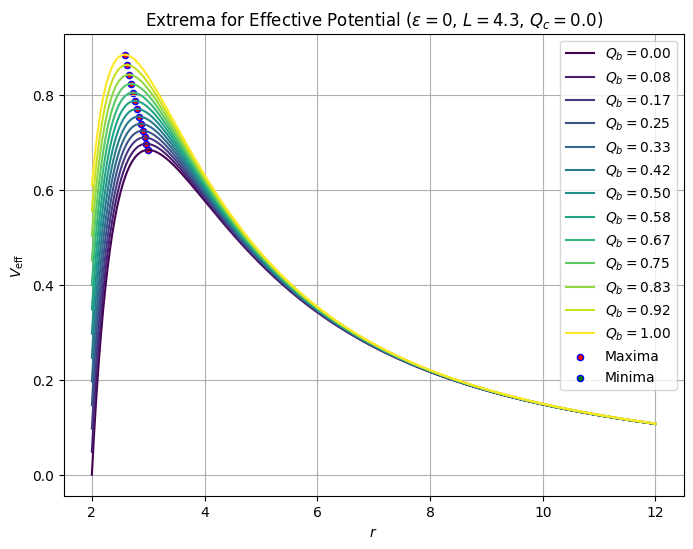

1st row of extrema data points (r, v_eff, E (at max v_eff), Q_b):
[[3.0 0.684814814814815 0.827535385838464 0.0]]


In [ ]:
#block 5 - find v_eff max for different values of Q_b and create array for the results
r_range = (rs1, 6 * rs1)
eps0 = 0

Q_b_vals = np.linspace(0, 1.0, 13)
colors = plt.cm.viridis(np.linspace(0, 1, len(Q_b_vals)))
plt.figure(figsize=(8, 6))
max_x, max_y, min_x, min_y = [], [], [], []

# array to store extrema data: r, v_eff, E(at max), Q_b
extrema_data = []

for Q_b, color in zip(Q_b_vals, colors):
    extrema, v_eff_func = find_extrema(M1, L1, Q_b, Q_c0, eps0, r_range)
    r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
    v_eff_func_num = sp.lambdify(r, v_eff_func, "numpy")
    v_eff_vals = v_eff_func_num(r_vals1)
    plt.plot(r_vals1, v_eff_vals, color=color, label=rf'$Q_b={Q_b:.2f}$')
    for r_ex, v_eff_at_r, ext_type in extrema:
        extrema_data.append((r_ex, v_eff_at_r, E_at_vmax(v_eff_at_r), Q_b))
        if ext_type == "max":
            max_x.append(r_ex)
            max_y.append(v_eff_at_r)
        else:
            min_x.append(r_ex)
            min_y.append(v_eff_at_r)

plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r_{\mathrm{s}}$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(rf"Extrema for Effective Potential ($\varepsilon={eps0}$, $L={L1}$, $Q_c={Q_c0}$)")
plt.legend()
plt.grid(True)
plt.show()

# NumPy array with extrema data including: r, v_eff, E (total energy), Q_b val
extrema_array = np.array(extrema_data)

# test print
print("1st row of extrema data points (r, v_eff, E (at max v_eff), Q_b):")
print(extrema_array[:1])


In [91]:
# test code
# print total energy, E, at v_eff max for given values of Q_b 
print(extrema_array[:, 2:4])

[[0.827535385838464 0.0]
 [0.835318103792172 0.08333333333333333]
 [0.843350278553077 0.16666666666666666]
 [0.851645805238964 0.25]
 [0.860219689481556 0.3333333333333333]
 [0.869088163931122 0.41666666666666663]
 [0.878268820012624 0.5]
 [0.887780757345027 0.5833333333333333]
 [0.897644753685770 0.6666666666666666]
 [0.907883458810288 0.75]
 [0.918521616406410 0.8333333333333333]
 [0.929586318886384 0.9166666666666666]
 [0.941107301035406 1.0]]


# Orbits

In this approach we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the equations of motion $\frac{dr}{d\lambda}$ and $\frac{d\phi}{d\lambda}$ with 'solve_ivp', then make a polar plot $r(\lambda)$ vs $\phi(\lambda)$ and convert to cartesian coordinates to plot y(x).

In the following code block we define the solver function, 'solve_r_phi_lamda', then in the next block we set initial conditions, run the solver, and plot. We can test starting the particle far away from the black hole and moving it inwards; or start relatively close in and move outwards. Next steps will be to change initial conditions to reproduce a circular, scattering and plunge orbit.

In [133]:
# block 6 - solver for geodesics equations for plotting orbits
def solve_geodesic(r_init, phi_init, t_init, lam_range, params, epsilon=0, inward=False):
    E, L, M, Q_b, Q_c = params  

    # initial conditions [t, r, phi]
    y0 = [t_init, r_init, phi_init]

    def dy_dt(lam, y):
        r = y[1]
        
        # stop integration if r <= Schwarzschild radius
        if r <= 2 * M + 1e-3:
            return [0, 0, 0] 

        dt_dlam, dr_dlam, dphi_dlam = eq_of_motion(lam, y, params, epsilon)

        if inward:
            dr_dlam = -abs(dr_dlam)  # dr/dλ is negative for inward motion
        else:
            dr_dlam = abs(dr_dlam)   # dr/dλ is positive for outward motion

        return [dt_dlam, dr_dlam, dphi_dlam]

    # solve for t(λ), r(λ), and φ(λ)
    sol = solve_ivp(dy_dt, lam_range, y0, t_eval=np.linspace(*lam_range, 1000), atol=1e-6, rtol=1e-6)
    
    return sol



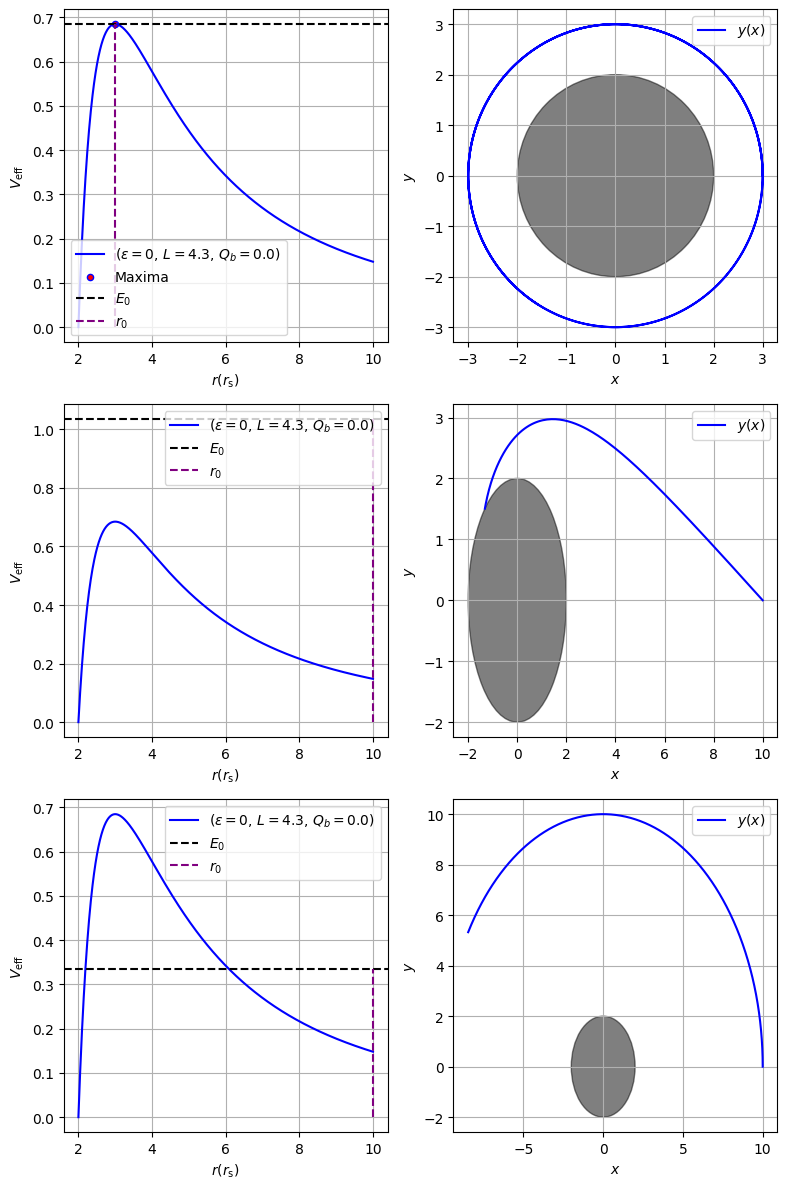

In [ ]:
# block 7 - plot geodesics
# same for all light particles around a SC black hole
Qb0 = extrema_array[0, 3]
Qc0 = 0.0
phi0 = 0
t0 = 0
lam_range = [0, 35]
lam_range_2 = [0, 60]
r0 = 5 * rs1
r_circ0 = 3 * M1

#----------- circular orbit
# parameters that change
E0_1 = extrema_array[0, 1] #v_eff at max (= E**2)
params1 = (E0_1, L1, M1, Qb0, Qc0)

r_vals0 = np.linspace(rs1, 5*rs1, 1000)
v_eff0 = np.array([v_eff(i, M1, L1, Qb0, Qc0, epsilon=0) for i in r_vals0])

# sol_outward = solve_geodesic(r_init, phi_init, t_init, lam_range, params)
sol_in_1 = solve_geodesic(r_circ0, phi0, t0, lam_range, params1, inward=True)

t_vals_1 = sol_in_1.y[0]
r_vals_1 = sol_in_1.y[1]
phi_vals_1 = sol_in_1.y[2]

# cartesian coordinates
x_vals_1 = r_vals_1 * np.cos(phi_vals_1)
y_vals_1 = r_vals_1 * np.sin(phi_vals_1)

#---------- E greater than circular -------------
E0_2 = E0_1 + 0.35
params2 = (E0_2, L1, M1, Qb0, Qc0)

# sol_outward = solve_geodesic(r_init, phi_init, t_init, lam_range, params)
sol_in_2 = solve_geodesic(r0, phi0, t0, lam_range_2, params2, inward=True)

t_vals_2 = sol_in_2.y[0]
r_vals_2 = sol_in_2.y[1]
phi_vals_2 = sol_in_2.y[2]

# cartesian coordinates
x_vals_2 = r_vals_2 * np.cos(phi_vals_2)
y_vals_2 = r_vals_2 * np.sin(phi_vals_2)

#---------- E less than circular -------------
E0_3 = E0_1 - 0.35
params3 = (E0_3, L1, M1, Qb0, Qc0)

# sol_outward = solve_geodesic(r_init, phi_init, t_init, lam_range, params)
sol_in_3 = solve_geodesic(r0, phi0, t0, lam_range_2, params3, inward=True)

t_vals_3 = sol_in_3.y[0]
r_vals_3 = sol_in_3.y[1]
phi_vals_3 = sol_in_3.y[2]

# cartesian coordinates
x_vals_3 = r_vals_3 * np.cos(phi_vals_3)
y_vals_3 = r_vals_3 * np.sin(phi_vals_3)

#--------- Plots -------------
fig, axes = plt.subplots(3, 2, figsize=(8, 12))  # Create 3x2 grid

# First plot
axes[0, 0].plot(r_vals0, v_eff0, label=rf"($\varepsilon={eps0}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[0, 0].scatter(extrema_array[0,0], extrema_array[0,1], color='r', s=20, edgecolors='b', label="Maxima")
axes[0, 0].axhline(y=E0_1, color='black', linestyle='--', label=r'$E_0$')
axes[0, 0].vlines(x=r_circ0, ymin=min(v_eff0), ymax=E0_1, color='purple', linestyle='--', label=r'$r_0$')
axes[0, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[0, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[0, 0].legend()
axes[0, 0].grid()

# Second plot
axes[0, 1].plot(x_vals_1, y_vals_1, label=r'$y(x)$', color='blue')
circle_0 = patches.Circle((0, 0), 2*M1, color='#010101', alpha=0.5)
axes[0, 1].add_patch(circle_0)
axes[0, 1].set_xlabel(r'$x$')
axes[0, 1].set_ylabel(r'$y$')
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot
axes[1, 0].plot(r_vals0, v_eff0, label=rf"($\varepsilon={eps0}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[1, 0].axhline(y=E0_2, color='black', linestyle='--', label=r'$E_0$')
axes[1, 0].vlines(x=r0, ymin=min(v_eff0), ymax=E0_2, color='purple', linestyle='--', label=r'$r_0$')
axes[1, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[1, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[1, 0].legend()
axes[1, 0].grid()

# Fourth plot
axes[1, 1].plot(x_vals_2, y_vals_2, label=r'$y(x)$', color='blue')
circle_1 = patches.Circle((0, 0), 2*M1, color='#010101', alpha=0.5)
axes[1, 1].add_patch(circle_1)
axes[1, 1].set_xlabel(r'$x$')
axes[1, 1].set_ylabel(r'$y$')
axes[1, 1].legend()
axes[1, 1].grid()

# Fifth plot
axes[2, 0].plot(r_vals0, v_eff0, label=rf"($\varepsilon={eps0}$, $L={L1}$, $Q_b={Qb0}$)", color='b')
axes[2, 0].axhline(y=E0_3, color='black', linestyle='--', label=r'$E_0$')
axes[2, 0].vlines(x=r0, ymin=min(v_eff0), ymax=E0_3, color='purple', linestyle='--', label=r'$r_0$')
axes[2, 0].set_xlabel(r'$r(r_{\mathrm{s}})$')
axes[2, 0].set_ylabel(r'$V_{\mathrm{eff}}$')
axes[2, 0].legend()
axes[2, 0].grid()

# Sixth plot
axes[2, 1].plot(x_vals_3, y_vals_3, label=r'$y(x)$', color='blue')
circle_2 = patches.Circle((0, 0), 2*M1, color='#010101', alpha=0.5)
axes[2, 1].add_patch(circle_2)
axes[2, 1].set_xlabel(r'$x$')
axes[2, 1].set_ylabel(r'$y$')
axes[2, 1].legend()
axes[2, 1].grid()

plt.tight_layout()
plt.show()

#---------------------------


In [ ]:
# block 6 - solver to compute t(lambda), r(lambda), phi(lambda)
# solve for r and phi as a function of tau using eq_of_motion
def solve_r_phi_lamda(params, lamda_range, r_init, phi_init, epsilon=0):

    E, L, M, Q_b, Q_c = params

    # initial conditions [t, r, phi]
    y0 = [0, r_init, phi_init] 

    def dy_dt(lamda, y):
        r = y[1]
    
        # stop integration if r is less than SC radius.
        if r <= 2*M + 1e-3:
            #print(f"Stopping integration: r={r:.5f} reached Schwarzschild radius at λ={lamda:.5f}")
            return [0, 0, 0] 

        dt_dlamda, dr_dlamda, dphi_dlamda = eq_of_motion(lamda, y, params, epsilon)

        #print(f"lambda={lamda:.3f}, r={y[1]:.5f}, dr/dlambda={dr_dlamda:.5f}, phi={y[2]:.5f}")
        return [dt_dlamda, dr_dlamda, dphi_dlamda]

    # solve for r(lambda) and phi(lambda)
    sol = solve_ivp(dy_dt, lamda_range, y0, t_eval=np.linspace(*lamda_range, 1000), atol=1e-6, rtol=1e-6)
    return sol


Extrema for ε = 0, L = 5.196152422706632, Q_b = 0.0, Q_c = 0.0:
r = 3.0000, v_eff = 1.0000, Type: max


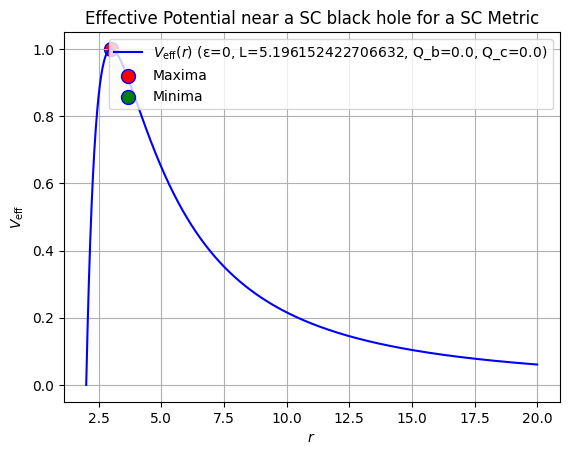

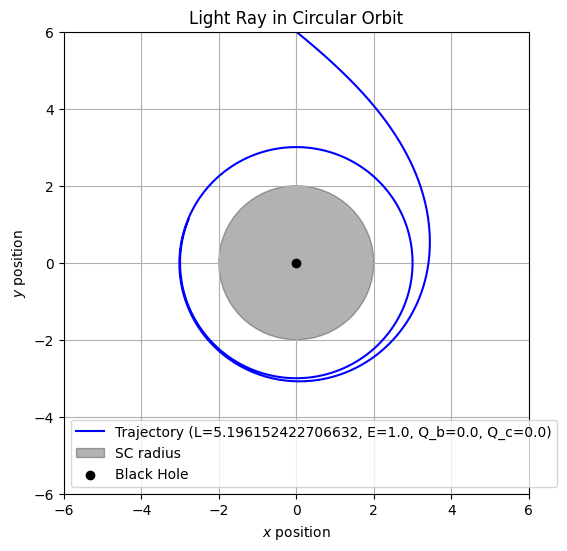

In [ ]:
# block 7A - light ray orbits
# circular orbits
r_range1 = (rs1, 10 * rs1)
# locate extrema for massless particles (epsilon = 0)
ext_photons1, v_eff_photons1 = find_extrema(M1, L1, Q_b0, Q_c0, eps0, r_range1)

r_vals1 = np.linspace(r_range1[0], r_range1[1], 1000)
v_eff_vals_sc1 = [v_eff_photons1.subs(r, rv) for rv in r_vals1]

# separate maxima, minima
max_x1, max_y1 = [], []
min_x1, min_y1 = [], []

for r_ex, v_eff_at_r, ext_type in ext_photons1:
    if ext_type == "max":
        max_x1.append(r_ex)
        max_y1.append(v_eff_at_r)
    else:
        min_x1.append(r_ex)
        min_y1.append(v_eff_at_r)

plt.plot(r_vals1, v_eff_vals_sc1, color='b', label=rf'$V_{{\mathrm{{eff}}}}(r)$ (ε={eps0}, L={L1}, Q_b={Q_b0}, Q_c={Q_c0})')
plt.scatter(max_x, max_y, color='r', s=20, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=20, edgecolors='b', label="Minima")
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title(f"Effective Potential near a SC black hole for a SC Metric")
plt.legend()
plt.grid(True)
plt.show()
# -------------
# initial conditions
r_init5 = 3 * rs1
phi_init5 = 0.5 * np.pi
lamda_range5 = [0, -23]

# NO quantum parameters
params5 = [E1, L_circle1, M1, Q_b0, Q_c0]

sol_y5 = solve_r_phi_lamda(params5, lamda_range5, r_init5, phi_init5, epsilon=0)

if not sol_y5.success:
    print("Integration failed:", sol_y5.message)

# extract radial and angular positions
r_vals5 = sol_y5.y[1]
phi_vals5 = sol_y5.y[2]
lamda_vals5 = sol_y5.t

# cartesian coordinates
x5 = r_vals5 * np.cos(phi_vals5)
y5 = r_vals5 * np.sin(phi_vals5)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x5, y5, color='b', label=f'Trajectory (L={L_circle1}, E={E1}, Q_b={Q_b0}, Q_c={Q_c0})')
circ = patches.Circle((0, 0), rs1, color='black', alpha=0.3, label="SC radius")
ax.add_patch(circ)
ax.scatter([0], [0], color='black', zorder=5, label='Black Hole')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_xlabel(r'$x$ position')
ax.set_ylabel(r'$y$ position')
plt.title('Light Ray in Circular Orbit')
ax.legend()
ax.grid(True)
plt.show()

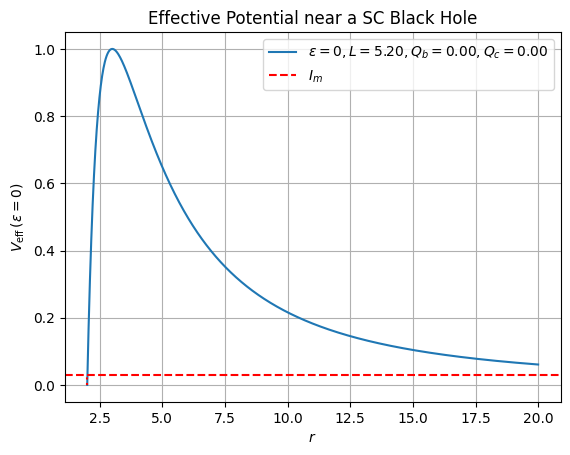

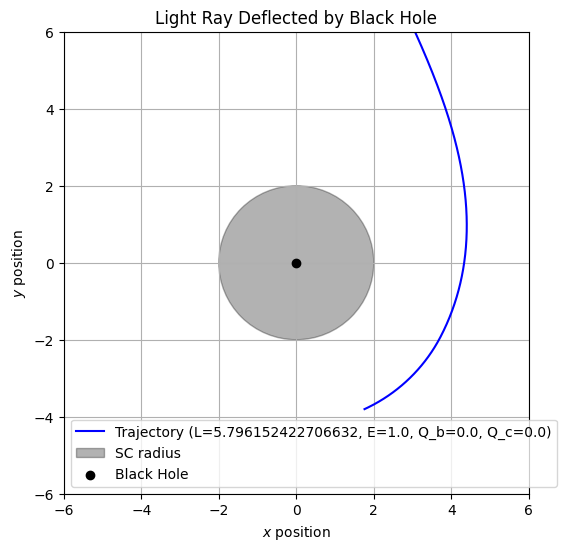

In [ ]:
# block 7B - light ray orbits
# orbits starting at infinity - scattering
# get list of effective potential values for sigma=0
v_eff_vals_sc2 = np.array([v_eff(i, M1, L_circle1, Q_b0, Q_c0, epsilon=0) for i in r_vals1])

plt.plot(r_vals1, v_eff_vals_sc2, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L_circle1, Q_b0, Q_c0))
# add horizontal line at Im_scatter1
plt.axhline(y=Im_scatter1, color='r', linestyle='dashed', label=r'$I_m$')
# find intersection point (r_intersect) where v_eff = Im_scatter1
v_eff_interp = interp1d(r_vals1, v_eff_vals_sc2, kind='linear', fill_value='extrapolate')
# find closest r value where v_eff(r) ≈ Im_scatter1 start from right-hand side
r_intersect = None
for r in reversed(r_vals1):
    if v_eff_interp(r) <= Im_scatter1:
        r_intersect = r
        break
if r_intersect:
    # vertical line downwards from intersection
    plt.vlines(x=r_intersect, ymin=0, ymax=Im_scatter1, color='r', linestyle='dotted')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 0)$')
plt.title('Effective Potential near a SC Black Hole')
plt.legend()
plt.grid(True)
plt.show()

#--------
# initial conditions
r_init4 = 6 * rs1
phi_init4 = 0.5 * np.pi
lamda_range4 = [0, -15]

# NO quantum parameters
params4 = [E1, L_scatter1, M1, Q_b0, Q_c0]

sol_y4 = solve_r_phi_lamda(params4, lamda_range4, r_init4, phi_init4, epsilon=0)

if not sol_y4.success:
    print("Integration failed:", sol_y4.message)

# extract radial and angular positions
r_vals4 = sol_y4.y[1]
phi_vals4 = sol_y4.y[2]
lamda_vals4 = sol_y4.t

# cartesian coordinates
x4 = r_vals4 * np.cos(phi_vals4)
y4 = r_vals4 * np.sin(phi_vals4)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x4, y4, color='b', label=f'Trajectory (L={L_scatter1}, E={E1}, Q_b={Q_b0}, Q_c={Q_c0})')
circ = patches.Circle((0, 0), rs1, color='black', alpha=0.3, label="SC radius")
ax.add_patch(circ)
ax.scatter([0], [0], color='black', zorder=5, label='Black Hole')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_xlabel(r'$x$ position')
ax.set_ylabel(r'$y$ position')
ax.set_title('Light Ray Deflected by Black Hole')
ax.legend()
ax.grid(True)
plt.show()

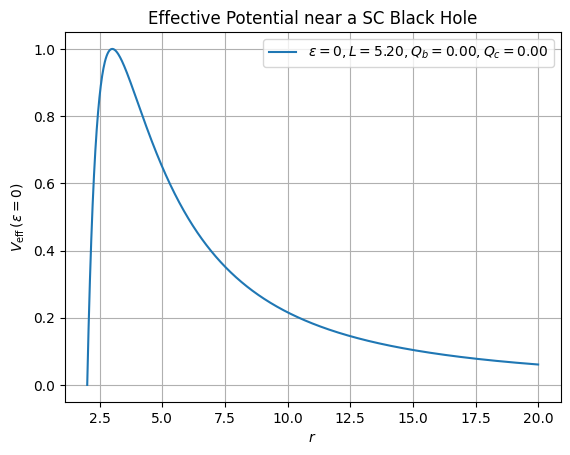

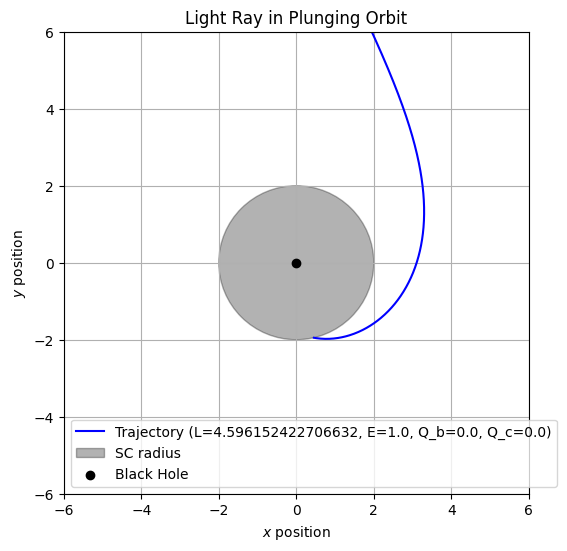

In [ ]:
# block 7C - light ray orbits
# starting from far out - plunging orbits

# get list of effective potential values for sigma=0
v_eff_vals_sc2 = np.array([v_eff(i, M1, L_circle1, Q_b0, Q_c0, epsilon=0) for i in r_vals1])
# plot the results epsilon = 0
plt.plot(r_vals1, v_eff_vals_sc2, label=r'$\epsilon=0, L={:.2f}, Q_b={:.2f}, Q_c={:.2f}$'.format(L_circle1, Q_b0, Q_c0))
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 0)$')
plt.title('Effective Potential near a SC Black Hole')
plt.legend()
plt.grid(True)
plt.show()
 
# initial conditions
r_init6 = 5 * rs1
phi_init6 = 0.5 * np.pi
lamda_range6 = [0, -12]

# NO quantum parameters
params6 = [E1, L_plunge1, M1, Q_b0, Q_c0]

sol_y6 = solve_r_phi_lamda(params6, lamda_range6, r_init6, phi_init6, epsilon=0)

if not sol_y6.success:
    print("Integration failed:", sol_y6.message)

# extract radial and angular positions
r_vals6 = sol_y6.y[1]
phi_vals6 = sol_y6.y[2]
lamda_vals6 = sol_y6.t

# cartesian coordinates
x6 = r_vals6 * np.cos(phi_vals6)
y6 = r_vals6 * np.sin(phi_vals6)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x6, y6, color='b', label=f'Trajectory (L={L_plunge1}, E={E1}, Q_b={Q_b0}, Q_c={Q_c0})')
circ = patches.Circle((0, 0), rs1, color='black', alpha=0.3, label="SC radius")
ax.add_patch(circ)
ax.scatter([0], [0], color='black', zorder=5, label='Black Hole')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_xlabel(r'$x$ position')
ax.set_ylabel(r'$y$ position')
ax.set_title('Light Ray in Plunging Orbit')
ax.legend()
ax.grid(True)
plt.show()
